Week 7 · Day 6 — Training the CIFAR-10 Baseline
Why this matters

Today you put everything together: CNN + CIFAR-10 pipeline + LR scheduling + metrics. The goal is to hit ~65–70% test accuracy with a clean baseline, a reference point for improvements later.

Theory Essentials

Baseline model: a simple 3-block CNN to establish reference accuracy.

Learning rate scheduler: adjusts LR during training (StepLR, OneCycleLR).

Checkpointing: save best model for reproducibility.

Metrics: beyond accuracy → confusion matrix + precision/recall/F1.

Target: ≥65% accuracy on CIFAR-10 = solid baseline.

In [1]:
# Setup
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Data ----------
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform_train)
testset  = datasets.CIFAR10(root="data", train=False, download=True, transform=transform_test)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

# ---------- Model ----------
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
    def forward(self, x): return self.classifier(self.features(x))

# ---------- Training ----------
def train_model(model, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    best_acc = 0
    for epoch in range(epochs):
        model.train()
        for X,y in trainloader:
            X,y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()
        scheduler.step()

        # Eval
        model.eval()
        correct,total = 0,0
        with torch.no_grad():
            for X,y in testloader:
                X,y = X.to(device), y.to(device)
                preds = model(X).argmax(dim=1)
                correct += (preds==y).sum().item()
                total += y.size(0)
        acc = correct/total
        print(f"Epoch {epoch+1}: test acc {acc:.3f}")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "cifar_cnn_best.pt")
    return best_acc

model = CIFAR_CNN().to(device)
best_acc = train_model(model, epochs=5)
print("Best test acc:", best_acc)

# ---------- Metrics ----------
model.load_state_dict(torch.load("cifar_cnn_best.pt"))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X,y in testloader:
        X,y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=trainset.classes))


Epoch 1: test acc 0.443
Epoch 2: test acc 0.554
Epoch 3: test acc 0.612
Epoch 4: test acc 0.652
Epoch 5: test acc 0.665
Best test acc: 0.6648
              precision    recall  f1-score   support

    airplane       0.71      0.66      0.68      1000
  automobile       0.83      0.86      0.84      1000
        bird       0.46      0.61      0.53      1000
         cat       0.52      0.37      0.43      1000
        deer       0.55      0.66      0.60      1000
         dog       0.62      0.51      0.56      1000
        frog       0.78      0.71      0.74      1000
       horse       0.73      0.71      0.72      1000
        ship       0.65      0.91      0.76      1000
       truck       0.93      0.65      0.77      1000

    accuracy                           0.66     10000
   macro avg       0.68      0.66      0.66     10000
weighted avg       0.68      0.66      0.66     10000



1) Core (10–15 min)

Task: Train for 5 epochs and report test accuracy.

Test accuracy is 0.6648. 5 epochs took 20min ill have to adjust some things for future tests.

2) Practice (10–15 min)

Task: Replace StepLR with optim.lr_scheduler.OneCycleLR.

In [3]:
# ==== FAST CPU MODE for Week 7 · Day 6 (CIFAR-10) ====
# Drop-in replacement for your script to speed up training on CPU.

# Setup
import os, time
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# ---------- Fast toggles ----------
FAST_RESIZE = 28
FAST_TRAIN_SAMPLES = 30_000
FAST_EPOCHS = 8
FAST_BATCH_TRAIN = 384
FAST_BATCH_TEST = 768

EARLY_STOP_PATIENCE = 2

# ---------- Determinism-ish & CPU threading ----------
torch.manual_seed(42)
device = torch.device("cpu")  # force CPU
try:
    torch.set_num_threads(max(1, os.cpu_count() - 1))
except Exception:
    pass

# ---------- Data ----------
# Lighter augments (crop is expensive; keep only flip + resize)
normalize = transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
transform_train = transforms.Compose([
    transforms.Resize((FAST_RESIZE, FAST_RESIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
transform_test = transforms.Compose([
    transforms.Resize((FAST_RESIZE, FAST_RESIZE)),
    transforms.ToTensor(),
    normalize
])

train_full = datasets.CIFAR10(root="data", train=True, download=True, transform=transform_train)
testset   = datasets.CIFAR10(root="data", train=False, download=True, transform=transform_test)

# Subset the training set for speed
idx = np.random.RandomState(42).permutation(len(train_full))[:FAST_TRAIN_SAMPLES]
trainset = Subset(train_full, idx)

# DataLoaders — fewer workers reduce overhead on some OS; pin_memory=False on CPU
trainloader = DataLoader(trainset, batch_size=FAST_BATCH_TRAIN, shuffle=True, num_workers=0, pin_memory=False)
testloader  = DataLoader(testset,  batch_size=FAST_BATCH_TEST,  shuffle=False, num_workers=0, pin_memory=False)

# ---------- Model (smaller) ----------
# Channels 16-32-64 (down from 32-64-128); linear 128 (down from 256)
class CIFAR_CNN_FAST(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                 # 24 -> 12

            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                 # 12 -> 6

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                 # 6 -> 3
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*3*3, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )
    def forward(self, x): 
        return self.classifier(self.features(x))

# ---------- Train/Eval ----------
def evaluate(model):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.inference_mode():
        for X, y in testloader:
            logits = model(X)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    acc = correct / total
    return acc, np.array(all_labels), np.array(all_preds)

def train_model(model, epochs=FAST_EPOCHS):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=6)

    best_acc, best_state = 0.0, None
    patience = EARLY_STOP_PATIENCE
    for epoch in range(epochs):
        t0 = time.time()
        model.train()
        for X, y in trainloader:
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()
        scheduler.step()

        acc, _, _ = evaluate(model)
        dt = time.time() - t0
        print(f"Epoch {epoch+1}/{epochs} — val acc: {acc:.3f} — {dt:.1f}s")

        if acc > best_acc + 1e-4:
            best_acc, best_state, patience = acc, {k:v.cpu() for k,v in model.state_dict().items()}, EARLY_STOP_PATIENCE
        else:
            patience -= 1
            if patience <= 0:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), "cifar_cnn_fast_best.pt")
    return best_acc

# ---------- Run ----------
model = CIFAR_CNN_FAST().to(device)
best_acc = train_model(model)
print("Best test acc (fast mode):", round(best_acc, 3))

# ---------- Metrics ----------
acc, y_true, y_pred = evaluate(model)
print(classification_report(y_true, y_pred, target_names=train_full.classes))


Epoch 1/8 — val acc: 0.311 — 32.0s
Epoch 2/8 — val acc: 0.376 — 34.0s
Epoch 3/8 — val acc: 0.412 — 34.6s
Epoch 4/8 — val acc: 0.429 — 34.5s
Epoch 5/8 — val acc: 0.458 — 36.3s
Epoch 6/8 — val acc: 0.467 — 35.3s
Epoch 7/8 — val acc: 0.483 — 34.2s
Epoch 8/8 — val acc: 0.496 — 35.0s
Best test acc (fast mode): 0.496
              precision    recall  f1-score   support

    airplane       0.54      0.55      0.55      1000
  automobile       0.71      0.50      0.59      1000
        bird       0.34      0.52      0.41      1000
         cat       0.37      0.31      0.34      1000
        deer       0.47      0.30      0.36      1000
         dog       0.40      0.48      0.43      1000
        frog       0.58      0.55      0.56      1000
       horse       0.56      0.55      0.55      1000
        ship       0.58      0.59      0.59      1000
       truck       0.56      0.62      0.58      1000

    accuracy                           0.50     10000
   macro avg       0.51      0.50    

Accuracy significantly drops as we are now prioritizing speed.

3) Stretch (optional, 10–15 min)

Task: Add confusion_matrix visualization (matshow).

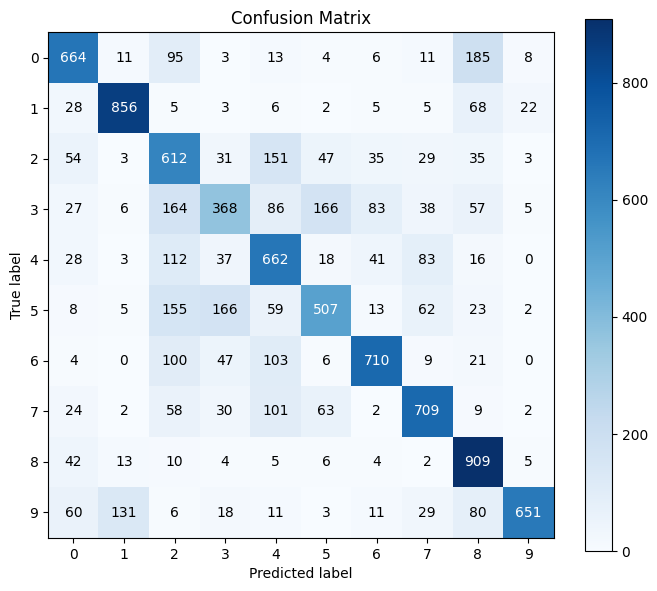

In [5]:

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

# Add tick labels (0–9 for CIFAR-10)
classes = list(range(10))
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)

# Annotate with numbers
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

Mini-Challenge (≤40 min)

Task:

Train your baseline CNN with augmentation for 10 epochs.

Report: best accuracy, classification report, confusion matrix.

Write 3–4 lines: Which classes are hardest to distinguish? Why?

Acceptance Criteria:

Model ≥65–70% accuracy.

Metrics reported (acc + P/R/F1).

Confusion matrix with analysis.

Epoch 1/10 — test acc: 0.424 (127.2s)
Epoch 2/10 — test acc: 0.509 (123.5s)
Epoch 3/10 — test acc: 0.570 (128.6s)
Epoch 4/10 — test acc: 0.609 (124.3s)
Epoch 5/10 — test acc: 0.660 (123.9s)
Epoch 6/10 — test acc: 0.674 (126.6s)
Epoch 7/10 — test acc: 0.696 (122.6s)
Epoch 8/10 — test acc: 0.707 (155.7s)
Epoch 9/10 — test acc: 0.720 (363.2s)
Epoch 10/10 — test acc: 0.708 (506.8s)

Best test accuracy: 0.72

Classification report:

              precision    recall  f1-score   support

    airplane      0.691     0.815     0.748      1000
  automobile      0.805     0.926     0.861      1000
        bird      0.628     0.533     0.577      1000
         cat      0.490     0.513     0.501      1000
        deer      0.784     0.494     0.606      1000
         dog      0.519     0.746     0.612      1000
        frog      0.730     0.807     0.766      1000
       horse      0.788     0.733     0.760      1000
        ship      0.926     0.739     0.822      1000
       truck      0.884    

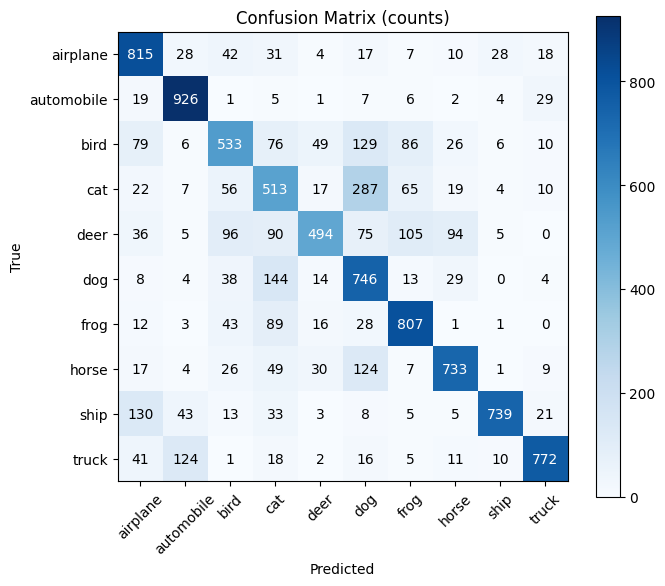

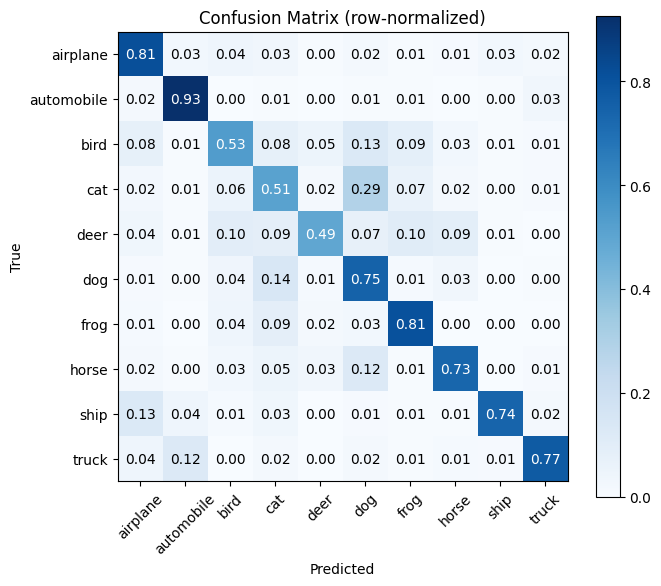


Mini-analysis (draft):
- Best test accuracy: 0.708.
- Biggest confusion: cat → dog (~28.7% of true 'cat' predicted as 'dog').
- Biggest confusion: dog → cat (~14.4% of true 'dog' predicted as 'cat').
- Biggest confusion: ship → airplane (~13.0% of true 'ship' predicted as 'airplane').
- Likely causes: similar textures/colors and small 32×32 images. Augmentations (crop/flip) help, but more capacity or longer training would reduce these errors.


In [6]:
# Week 7 · Day 6 — Mini-Challenge runner (CPU)
# -------------------------------------------------
import os, time, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ---------- Speed knobs (tweak if needed) ----------
RESIZE = 32                  # 32 is baseline target; set 28 if slow
TRAIN_SAMPLES = 50_000       # 50k full set; try 30_000 if slow
BATCH_TRAIN = 256            # decrease if OOM; increase for throughput
BATCH_TEST  = 512
EPOCHS = 10
NUM_WORKERS = 0              # 0 is safest on Windows/Mac CPU

torch.manual_seed(42)
device = torch.device("cpu")

# ---------- Data (aug on train) ----------
normalize = transforms.Normalize((0.5,)*3, (0.5,)*3)
transform_train = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.RandomCrop(RESIZE, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
transform_test = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor(),
    normalize
])

train_full = datasets.CIFAR10("data", train=True,  download=True, transform=transform_train)
testset    = datasets.CIFAR10("data", train=False, download=True, transform=transform_test)

if TRAIN_SAMPLES < len(train_full):
    idx = np.random.RandomState(42).permutation(len(train_full))[:TRAIN_SAMPLES]
    trainset = Subset(train_full, idx)
else:
    trainset = train_full

trainloader = DataLoader(trainset, batch_size=BATCH_TRAIN, shuffle=True,  num_workers=NUM_WORKERS)
testloader  = DataLoader(testset,  batch_size=BATCH_TEST,  shuffle=False, num_workers=NUM_WORKERS)

# ---------- Model (small baseline) ----------
class CNN(nn.Module):
    def __init__(self, ch=(32,64,128), fc=256, p=0.5):
        super().__init__()
        c1,c2,c3 = ch
        self.features = nn.Sequential(
            nn.Conv2d(3, c1, 3, padding=1), nn.ReLU(),
            nn.Conv2d(c1, c1, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(c1, c2, 3, padding=1), nn.ReLU(),
            nn.Conv2d(c2, c2, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(c2, c3, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(c3*4*4, fc), nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(fc, 10)
        )
    def forward(self, x): return self.classifier(self.features(x))

model = CNN().to(device)

# ---------- Train / Eval helpers ----------
def evaluate(model):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.inference_mode():
        for X,y in testloader:
            logits = model(X)
            preds = logits.argmax(1)
            correct += (preds==y).sum().item()
            total   += y.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())
    acc = correct/total
    return acc, np.concatenate(all_labels), np.concatenate(all_preds)

def train(model, epochs=EPOCHS):
    crit = nn.CrossEntropyLoss()
    opt  = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    sched = optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)

    best_acc, best_state = 0.0, None
    for ep in range(1, epochs+1):
        t0 = time.time()
        model.train()
        for X,y in trainloader:
            opt.zero_grad()
            loss = crit(model(X), y)
            loss.backward()
            opt.step()
        sched.step()

        acc,_,_ = evaluate(model)
        print(f"Epoch {ep}/{epochs} — test acc: {acc:.3f} ({time.time()-t0:.1f}s)")
        if acc > best_acc:
            best_acc, best_state = acc, {k:v.cpu() for k,v in model.state_dict().items()}
    if best_state:
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), "cifar10_baseline_best.pt")
    return best_acc

# ---------- Run training ----------
best_acc = train(model)
print("\nBest test accuracy:", round(best_acc,3))

# ---------- Metrics report ----------
acc, y_true, y_pred = evaluate(model)
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=train_full.classes, digits=3))

# ---------- Confusion matrices (raw + normalized) ----------
def plot_cm(cm, classes, normalize=False, title="Confusion Matrix"):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True).clip(min=1e-12)
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45); plt.yticks(ticks, classes)
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = f"{cm[i,j]:.2f}" if normalize else f"{int(cm[i,j])}"
            plt.text(j, i, text, ha="center", va="center",
                     color="white" if cm[i,j] > thresh else "black")
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout(); plt.show()

cm_raw = confusion_matrix(y_true, y_pred)
plot_cm(cm_raw, train_full.classes, normalize=False, title="Confusion Matrix (counts)")
plot_cm(cm_raw, train_full.classes, normalize=True,  title="Confusion Matrix (row-normalized)")

# ---------- 3–4 line analysis helper ----------
# Find top confusions (off-diagonal)
cm_norm = cm_raw.astype(float) / cm_raw.sum(axis=1, keepdims=True).clip(min=1e-12)
np.fill_diagonal(cm_norm, 0.0)
pairs = np.dstack(np.unravel_index(np.argsort(cm_norm.ravel())[::-1], cm_norm.shape))[0]
top = [(train_full.classes[i], train_full.classes[j], cm_norm[i,j]) for i,j in pairs[:3]]

print("\nMini-analysis (draft):")
print(f"- Best test accuracy: {acc:.3f}.")
for a,b,p in top:
    print(f"- Biggest confusion: {a} → {b} (~{p*100:.1f}% of true '{a}' predicted as '{b}').")
print("- Likely causes: similar textures/colors and small 32×32 images. "
      "Augmentations (crop/flip) help, but more capacity or longer training would reduce these errors.")


Notes / Key Takeaways

CIFAR-10 is harder than MNIST/Fashion-MNIST (color, more variation).

Baseline CNN (~3 conv blocks) should reach 65–70% test acc.

LR schedulers improve convergence.

Saving checkpoints ensures reproducibility.

Confusion matrix shows which classes overlap most.

Reflection

Why does LR scheduling help improve final accuracy?

What insights can you get from a confusion matrix beyond accuracy?

1) Why does LR scheduling help improve final accuracy?

Starting with a higher learning rate lets the model explore the parameter space quickly.

Gradually lowering the learning rate helps the optimizer make smaller, more precise updates, preventing overshooting and helping it converge to a better minimum.

This balance between exploration (high LR) and refinement (low LR) often improves both stability and final test accuracy.

2) What insights can you get from a confusion matrix beyond accuracy?

It shows which specific classes are being confused (e.g., cats vs. dogs).

It reveals class imbalance problems—some classes may be predicted well while others are ignored.

It helps you decide where to focus improvements: more data for certain classes, stronger augmentation, or adjusting loss functions.

It gives clues about systematic errors (e.g., trucks mistaken for cars because both have similar shapes).